In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
import pickle
import pandas as pd
import numpy as np

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nltk

In [3]:
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS

In [5]:
article_dict = {}
f = open("IndiaNewsArticleText.pickle", "rb")
article_dict = pickle.load(f)

In [6]:
print(article_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])


In [12]:
news_df = pd.DataFrame.from_dict(article_dict).transpose()
news_df.head()

,Date,Text
0,2021-06-11,New Delhi: The Supreme Court on Friday asked t...
1,2021-06-04,New Delhi: With the second wave of Covid-19 ca...
2,2021-05-22,New Delhi: As the coronavirus cases are declin...
3,2021-05-13,New Delhi: The Supreme Court on Thursday direc...
4,2021-04-20,New Delhi: Hours after Delhi Chief Minister Ar...


In [13]:
print(news_df.shape)

(120, 2)


In [14]:
from sklearn.feature_extraction import text
from nltk import pos_tag

import re
import nltk
import string
from nltk.corpus import stopwords

In [15]:
def my_tokenizer(text):
    return re.split("\\s+",text)

def pos_filter(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = my_tokenizer(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

round1 = lambda x: pos_filter(x)

In [16]:
my_stop_words = []

def clean_tokens(text):
    text = re.sub('\w*\d\w*', '', text)
    text = text.lower()
    tok = my_tokenizer(text)
    tok = [char for char in tok if char not in string.punctuation]
    tok = [word for word in tok if len(word) >= 3 and word not in my_stop_words]

    text = ' '.join(tok)

    return text

In [20]:
post_pos_filter_data = pd.DataFrame(news_df['Text'].apply(round1))
data_clean = pd.DataFrame(post_pos_filter_data['Text'].apply(clean_tokens))
news_df['Text'] = data_clean['Text']
news_df.head()

,Date,Text
0,2021-06-11,new delhi: supreme court friday west bengal go...
1,2021-06-04,new delhi: second wave covid- cases migrant wo...
2,2021-05-22,"new delhi: coronavirus cases national capital,..."
3,2021-05-13,"new delhi: supreme court thursday centre, othe..."
4,2021-04-20,new delhi: hours delhi chief minister arvind k...


In [21]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    print("Inside get_topic_words")
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:20])), word_counts))
    print("TOPICS", topics)

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    print("Inside get_coherence")
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)

def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    print("Inside visualize")
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/Users/aproy/DS/venv/kaggle/working/contextual_topic_identification/docs/images/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/Users/aproy/DS/venv/kaggle/working/2D_vis')
    
def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    print("Inside get_wordcloud")
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)
    

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/Users/aproy/DS/venv/kaggle2/working/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/Users/aproy/DS/venv/kaggle2/working' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))


In [22]:
from nltk.stem.porter import PorterStemmer
import re
import nltk
from sklearn.feature_extraction import text


###################################
#### sentence and word level preprocess ####
###################################

add_stop_words = []
my_stopwords = text.ENGLISH_STOP_WORDS.union(add_stop_words)

def preprocess_sentence(text):
    
    my_punctuation = '!"$%&\'()*,-./:;<=>?[\\]^_`{|}~•@–'
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('…', '', text)
    text = re.sub('['+my_punctuation+']+', ' ', text)
    text_list = text_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords
    text = ' '.join(text_list)

    return text.strip()

def preprocess_word(text):

    word_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords
    
    return word_list

In [23]:
def preprocess(docs):
    """
    Preprocess the data
    """

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    for idx in range(n_docs):
        sentence = preprocess_sentence(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


In [24]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=80, batch_size=64):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=80,
                                        batch_size=64,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime
import time

In [26]:
class Topic_Model:
    def __init__(self, k=4, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 20  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec
        
        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                lda = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=80, iterations=3000)
                self.ldamodel = lda
                print(lda.print_topics())
            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec
        
        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec
        
    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=120, iterations=3000)
                print(self.ldamodel.print_topics())
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')
    
    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for LDA ...
[(0, '0.131*"" + 0.013*"workers" + 0.013*"migrant" + 0.007*"police" + 0.007*"read" + 0.006*"people" + 0.005*"”" + 0.005*"lockdown" + 0.005*"food" + 0.005*"covid"'), (1, '0.005*"coal" + 0.005*"assam" + 0.005*"illegal" + 0.004*"district" + 0.004*"hills" + 0.004*"jaintia" + 0.004*"east" + 0.003*"pit" + 0.002*"meghalaya" + 0.002*"hole"'), (2, '0.113*"" + 0.028*"sonu" + 0.024*"sood" + 0.018*"actor" + 0.018*"workers" + 0.016*"migrant" + 0.011*"home" + 0.010*"read" + 0.008*"people" + 0.007*"mumbai"'), (3, '0.156*"" + 0.017*"workers" + 0.016*"migrant" + 0.012*"lockdown" + 0.010*"read" + 0.008*"home" + 0.007*"state" + 0.007*"people" + 0.007*"delhi" + 0.007*"”"')]
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 4/4 [00:34<00:00,  8.59s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
VISUALIZE...
Inside visualize
Calculating UMAP projection ...
Calculating UMAP projection. Done!
Inside get_wordcloud
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Inside get_wordcloud
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Inside get_wordcloud
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Inside get_wordcloud
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Inside get_topic_words
TOPICS [['workers', 'migrant', 'lockdown', 'read', 'home', 'state', 'people', '”', 'delhi', 'government', 'migrants', 'covid', 'trains', 'guidelines', 'chief', 'states', 'twitter', 'govt', 'labourers', 'india'], ['workers', 'migrant', 'read', 'police', 'people', 'lockdown', '”', 'food', 'covid', 'noida', 'kamalathal', 'home', 'twitter', 'government', 'minister', 'india', 'old', 'poor

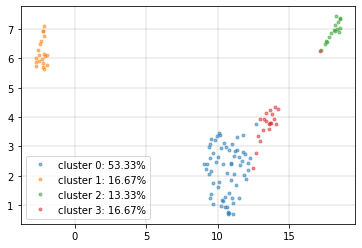

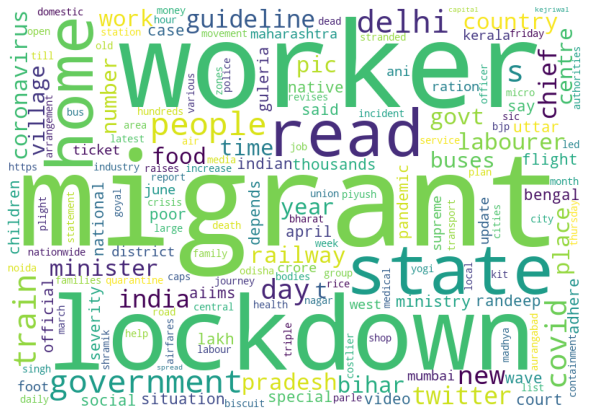

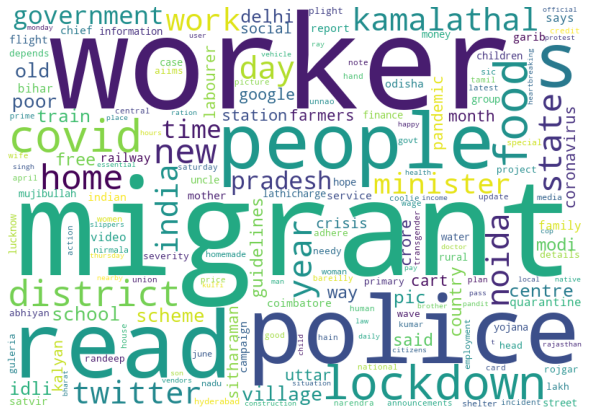

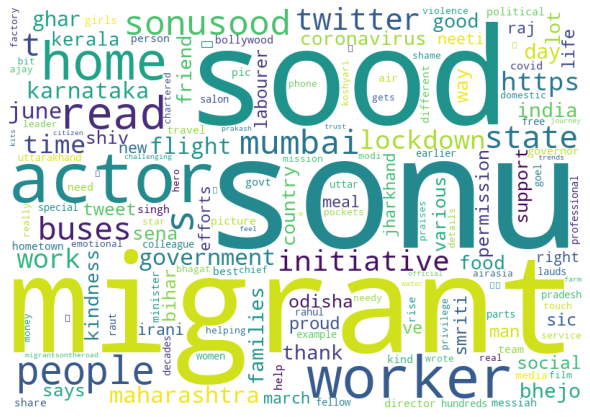

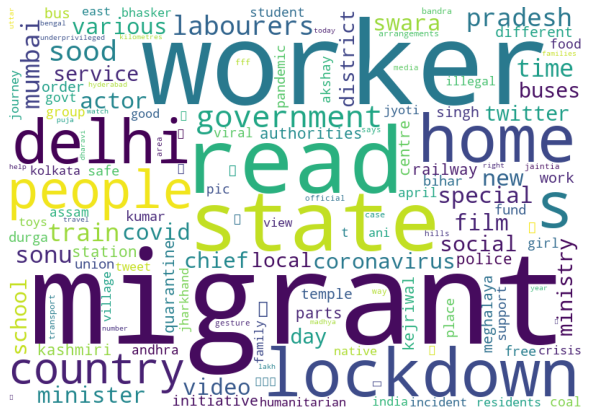

In [27]:
#Preprocess

method = "LDA_BERT"
num_topics = 4

articles = news_df['Text']
sentences, token_lists, idx  = preprocess(articles)

tm = Topic_Model(k = num_topics, method = method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)

#print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
#print('Silhouette Score:', get_silhouette(tm))
# visualize and save img
print("VISUALIZE...")
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

topics = get_topic_words(token_lists, tm.cluster_model.labels_)